#VoiceRecognition wav file exploration and understanding

This notebook is to understand the data format and layout of recording using Python Wave, wav files, and numpy arrays all representing the same underlying audio

##1) Set up the environment

###Prep
Import what we need

In [1]:
import wave
import numpy as np
import struct
from array import array
import sys
import pyaudio

###Config for the stream

In [48]:
THRESHOLD = 150  # Originally 500, but new is_silent() works better with this value
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 44100

RECORD_SECONDS = 4

##Either 
##2a) Record from microphone
To start with new audio, this section of the code will record audio from the microphone and process it to create a vector

In [50]:
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK_SIZE * RECORD_SECONDS)):
    stream_data = stream.read(CHUNK_SIZE)
    frames.append(stream_data) # 2 bytes(16 bits) per channel
    # print len(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

* recording
* done recording


###Display some information on what we've recorded

*len(data) will show us how much data is captured durectly from stream.read() based on our CHUNK_SIZE
*len(frames) will show us how much data has been recorded directly into our frames buffer

In [51]:
print "Data recorded for each stream.read(): ", len(stream_data)
print "Total number of frames captured in frames: ", len(frames)


Data recorded for each stream.read():  2048
Total number of frames captured in frames:  172


In [52]:
print "Number of CHUNKs recorded in total:", len(stream_data) * len(frames)

Number of CHUNKs recorded in total: 352256


###Write this file to disk for later

In [53]:
wf = wave.open("testing.wav", 'wb')
wf.setnchannels(1)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes('b'.join(frames))
wf.close()

###Using Numpy
Let's view some of this data in numpy as that's have we're going to manipulate it.

1) First we need to convert the frames data from integer into string (or can we get around this without as the stream.read() call returns a string in data???

In [54]:
fs = ",".join(str(f) for f in frames)
audio_data = np.array(struct.unpack_from(
        "%dh" % len(frames)*CHUNK_SIZE, 
        fs))

# Now print some stats about what we've just created in np and a snippet of the numpy array
print audio_data.shape
print audio_data[4000:4500]

(176128,)
[ -6146 -27139  28157  27645 -30211 -21251 -16899 -16131 -17155 -17411
 -13571  -2819  15101 -28674  -6914  13054  30463 -20481 -13057 -14337
 -24577  23807   6143  -6401 -13058 -15618 -17922 -20738 -23554 -21506
  -9474  10750 -31233  -7425  11775  26368 -27392 -16128  -2816   7936
  11265   2561 -17663  23552   3584  -5376  -2305   7167  16640  19456
   8448 -11264  31999   9215 -10753 -23810 -29442 -27138 -16642   4350
 -30721   6399 -18688  20480 -12799  10497  25346  31746  29698  20482
   5890 -12542  32513  15105   2817  -6911 -15616 -22016 -25088 -27392
 -29952 -30464 -32256  28928  24832  23808  24576  26624  29440  32256
  32512  30720  29696  29184  28416  29952 -29696  11264    149    125
     79     28    -18    -54    -71    -77    -87   -106   -126   -142
   -147   -127    -90    -53    -27    -12     -9    -20    -30    -24
    -11     -6    -14    -48   -121   -228   -338   -425   -476   -475
   -432   -367   -301   -234   -163    -93    -21     68    170    

###Now start to process features
In this part of the code we are going to extract the features from the audio following a [Mel Frequency Cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) algorithm so that we can analyse them.


We are now going to use my modified version of [Hanoop Hallur's](https://github.com/anooprh/PyOhio-Prsesentation) code to extract features from the audio into a vector. For testing purposes we'll also write the feature vectors to a file in case we want to use them later for training or testing purposes.

In [55]:
from audioUtils import extractfeatures as features
from audioUtils import audioconfig as config
import time

sample_time = time.time()
features = features.extractfeatures(audio_data)
features_filename = "features.data/features-" + str(sample_time) + ".data"
print "Writing features to " + features_filename
np.savetxt(features_filename, features)

Writing features to features.data/features-1461502781.54.data


##Or 
##2b) Load features from an existing file
Currently allow loading a single file at a time, but will move to directory loading later to allow training and testing

In [29]:
filename="features-1460954637.68.data"  #Need to manually set the filename to load
directory="./features.data"

features_filename=directory + "/" + filename
features = np.loadtxt(features_filename)


Now let's just get some basic stats about the data, graph something and see what it looks like!!
Perhaps use PCA to reduce the dimensionality of it.

Note that in extractfeatures.py we take the first 13 features, but we end up with 39. This is because we do deltas, and a delta of the delta.

In [30]:
print features.shape
print features

(398, 39)
[[-6.53526886 -0.9715505  -0.64099675 ...,  1.79185136  2.49326465
   1.08846445]
 [-0.12818802  1.77911877 -1.2833889  ...,  1.44859469  1.25978634
   0.63621454]
 [ 0.44579733  1.751763   -0.43511441 ..., -2.96634411 -1.8478465
  -0.49015036]
 ..., 
 [-0.50709185 -0.03404285  0.80066366 ...,  0.58940861  0.3052032
   0.3856267 ]
 [-0.2131692  -0.09474923  0.75468528 ...,  0.01359105  0.53554717
   0.84286746]
 [ 0.34337859 -0.65135324 -0.04672547 ..., -0.2571058   0.10445008
  -0.01134042]]


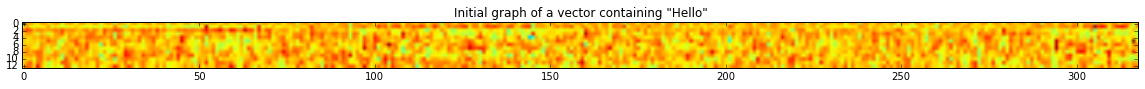

In [56]:
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

#Start by transposing features so that the graph is longer in the x-direction
features_t = features[:, 0:13].transpose()

#Now split out into original, delta and delta-delta

plt.figure(figsize=(20,5))
plt.clf()
plt.imshow(features_t)
plt.title('Initial graph of a vector containing "Hello"')
plt.show()
plt.close()

Now see if we can graph each feature over the duration to get a view of what it looks like.
Note this is to get a better understanding of pyplot too!

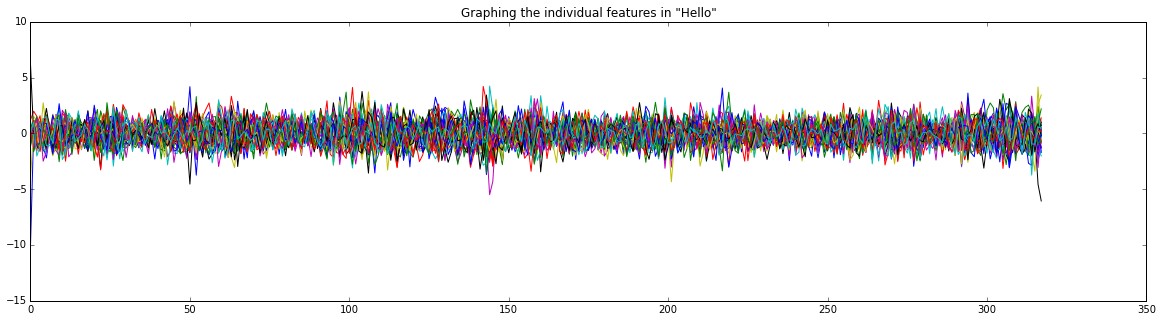

In [57]:
features_t = features.transpose()    # Let's use all of the features this time (including deltas and delta-deltas)
 
plt.figure(figsize=(20,5))
plt.clf()
x=np.arange(0,389)
for f in features_t:
    plt.plot(f)
plt.title('Graphing the individual features in "Hello"')
plt.show()
plt.close()


Now let's see what happens if we reshape to a (1, 389x39)

In [58]:
def reshape_features(features):
    features_vector = features.reshape(-1, 398 * 39)   #TODO - Will this always be 389???
    return features_vector

In [59]:
def plot_features(features_vector, title):        
    x_max = max(0,features_vector.shape[1])
    y_min, y_max = features_vector[0, :].min(), features_vector[0,:].max()
    plt.figure(figsize=(20,5))
    plt.clf()
    plt.xlim(0, x_max)
    plt.ylim(y_min, y_max)
    plt.plot(features_vector[0])
    plt.title(title)
    plt.show()
    plt.close()

In [60]:
features_vector = reshape_features(features_t)    # Use the transposed features matrix
plot_features(features_vector, 'Graphing the individual features in "Hello" after reshaping')

ValueError: total size of new array must be unchanged

##3) Load all data in the directory
This is the start of training a model based on recordings that we have made previously

In [47]:
features_all = np.array(np.zeros(shape=(398*39)))

import os
features_directory="./features.data"  # Just in case we don't have it previously

for filename in os.listdir(features_directory):
    print "Loading features from : ", filename
    features_filename=directory + "/" + filename
    features = np.loadtxt(features_filename)
    features_vector = reshape_features(features.transpose())
    np.append(features_all, features_vector[0], axis=0)

print features_all.shape
print features_all


Loading features from :  features-1460954461.44.data
Loading features from :  features-1460954637.68.data
Loading features from :  features-1460958436.51.data
Loading features from :  features-1460958813.67.data
(15522,)
[ 0.  0.  0. ...,  0.  0.  0.]
